# ORF recognition by CNN

Same as 116 but let 5'UTR vary from 0 to 6 so memorizing specific STOP positions is harder.  

In [36]:
import time 
t = time.time()
time.strftime('%Y-%m-%d %H:%M:%S %Z', time.localtime(t))

'2021-06-11 19:20:08 UTC'

In [37]:
PC_SEQUENCES=4000   # how many protein-coding sequences
NC_SEQUENCES=4000   # how many non-coding sequences
PC_TESTS=1000
NC_TESTS=1000
RNA_LEN=36            # how long is each sequence
CDS_LEN=30            # include bases in start, residues, stop
ALPHABET=4          # how many different letters are possible
INPUT_SHAPE_2D = (RNA_LEN,ALPHABET,1) # Conv2D needs 3D inputs
INPUT_SHAPE = (RNA_LEN,ALPHABET) # Conv1D needs 2D inputs
FILTERS = 16   # how many different patterns the model looks for
NEURONS = 16
DROP_RATE = 0.4
WIDTH = 3   # how wide each pattern is, in bases
STRIDE_2D = (1,1)  # For Conv2D how far in each direction
STRIDE = 1 # For Conv1D, how far between pattern matches, in bases
EPOCHS=25  # how many times to train on all the data
SPLITS=5  # SPLITS=3 means train on 2/3 and validate on 1/3 
FOLDS=5  # train the model this many times (range 1 to SPLITS)

In [38]:
import sys
try:
    from google.colab import drive
    IN_COLAB = True
    print("On Google CoLab, mount cloud-local file, get our code from GitHub.")
    PATH='/content/drive/'
    #drive.mount(PATH,force_remount=True)  # hardly ever need this
    #drive.mount(PATH)    # Google will require login credentials
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
    import requests
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_gen.py')
    with open('RNA_gen.py', 'w') as f:
        f.write(r.text)  
    from RNA_gen import *
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_describe.py')
    with open('RNA_describe.py', 'w') as f:
        f.write(r.text)  
    from RNA_describe import ORF_counter
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_prep.py')
    with open('RNA_prep.py', 'w') as f:
        f.write(r.text)  
    from RNA_prep import *
except:
    print("CoLab not working. On my PC, use relative paths.")
    IN_COLAB = False
    DATAPATH='data/'  # must end in "/"
    sys.path.append("..") # append parent dir in order to use sibling dirs
    from SimTools.RNA_gen import *
    from SimTools.RNA_describe import ORF_counter
    from SimTools.RNA_prep import *

MODELPATH="BestModel"  # saved on cloud instance and lost after logout
#MODELPATH=DATAPATH+MODELPATH  # saved on Google Drive but requires login

if not assert_imported_RNA_gen():
    print("ERROR: Cannot use RNA_gen.")
if not assert_imported_RNA_prep():
    print("ERROR: Cannot use RNA_prep.")

On Google CoLab, mount cloud-local file, get our code from GitHub.


In [39]:
from os import listdir
import csv
from zipfile import ZipFile

import numpy as np
import pandas as pd
from scipy import stats  # mode

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from keras.models import Sequential
from keras.layers import Dense,Embedding,Dropout
from keras.layers import Conv1D,Conv2D
from keras.layers import Flatten,MaxPooling1D,MaxPooling2D
from keras.losses import BinaryCrossentropy
# tf.keras.losses.BinaryCrossentropy

import matplotlib.pyplot as plt
from matplotlib import colors
mycmap = colors.ListedColormap(['red','blue'])  # list color for label 0 then 1
np.set_printoptions(precision=2)

In [40]:
import random
def partition_random_sequences(goal_per_class):
    between_bases = CDS_LEN - 6
    utr5_bases = random.randint(0,RNA_LEN-CDS_LEN) 
    utr3_bases = RNA_LEN - utr5_bases - CDS_LEN
    pc_seqs=[]
    nc_seqs=[]
    oc = ORF_counter()
    trials = 0
    pc_cnt = 0
    nc_cnt = 0
    bases=['A','C','G','T']
    while pc_cnt<goal_per_class or nc_cnt<goal_per_class:
        trials += 1        
        one_seq  = "".join(random.choices(bases,k=utr5_bases)) 
        one_seq += 'ATG'    
        random_cnt = random.randint(1,between_bases-3)
        one_seq += "".join(random.choices(bases,k=random_cnt))
        random_stop = random.choice(['TAA','TAG','TGA']) # random frame
        one_seq += random_stop
        remaining_cnt = between_bases - 3 - random_cnt
        one_seq += "".join(random.choices(bases,k=remaining_cnt))        
        #one_seq += "".join(random.choices(bases,k=between_bases)) 
        random_stop = random.choice(['TAA','TAG','TGA']) # in frame
        one_seq += random_stop
        one_seq += "".join(random.choices(bases,k=utr3_bases))  
        oc.set_sequence(one_seq)
        cds_len = oc.get_max_cds_len() + 3
        if cds_len >= CDS_LEN and pc_cnt<goal_per_class:
            pc_cnt += 1
            pc_seqs.append(one_seq)
        elif cds_len < CDS_LEN and nc_cnt<goal_per_class:
            nc_cnt += 1
            nc_seqs.append(one_seq)
    print ("It took %d trials to reach %d per class."%(trials,goal_per_class))
    return pc_seqs,nc_seqs
pc_all,nc_all=partition_random_sequences(10)  # just testing
pc_all,nc_all=partition_random_sequences(PC_SEQUENCES+PC_TESTS)
print("Use",len(pc_all),"PC seqs")
print("Use",len(nc_all),"NC seqs")

It took 28 trials to reach 10 per class.
It took 11255 trials to reach 5000 per class.
Use 5000 PC seqs
Use 5000 NC seqs


In [41]:
# Describe the sequences
def describe_sequences(list_of_seq):
    oc = ORF_counter()
    num_seq = len(list_of_seq)
    rna_lens = np.zeros(num_seq)
    orf_lens = np.zeros(num_seq)
    for i in range(0,num_seq):
        rna_len = len(list_of_seq[i])
        rna_lens[i] = rna_len
        oc.set_sequence(list_of_seq[i])
        orf_len = oc.get_max_orf_len()
        orf_lens[i] = orf_len
    print ("Average RNA length:",rna_lens.mean())
    print ("Average ORF length:",orf_lens.mean())
    
print("Simulated sequences prior to adjustment:")
print("PC seqs")
describe_sequences(pc_all)
print("NC seqs")
describe_sequences(nc_all)

Simulated sequences prior to adjustment:
PC seqs
Average RNA length: 36.0
Average ORF length: 26.8044
NC seqs
Average RNA length: 36.0
Average ORF length: 12.2484


In [42]:
pc_train=pc_all[:PC_SEQUENCES]
nc_train=nc_all[:NC_SEQUENCES]
pc_test=pc_all[PC_SEQUENCES:]
nc_test=nc_all[NC_SEQUENCES:]

In [43]:
# Use code from our SimTools library.
X,y = prepare_inputs_len_x_alphabet(pc_train,nc_train,ALPHABET) # shuffles
print("Data ready.")

Data ready.


In [44]:
def make_DNN():
    print("make_DNN")
    print("input shape:",INPUT_SHAPE)
    dnn = Sequential()
    #dnn.add(Embedding(input_dim=INPUT_SHAPE,output_dim=INPUT_SHAPE)) 
    dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same",
            input_shape=INPUT_SHAPE))
    dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same"))
    dnn.add(MaxPooling1D())
    #dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same"))
    #dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same"))
    #dnn.add(MaxPooling1D())
    dnn.add(Flatten())
    dnn.add(Dense(NEURONS,activation="sigmoid",dtype=np.float32))   
    dnn.add(Dropout(DROP_RATE))
    dnn.add(Dense(1,activation="sigmoid",dtype=np.float32))   
    dnn.compile(optimizer='adam',
                loss=BinaryCrossentropy(from_logits=False),
                metrics=['accuracy'])   # add to default metrics=loss
    dnn.build(input_shape=INPUT_SHAPE)
    #ln_rate = tf.keras.optimizers.Adam(learning_rate = LN_RATE)
    #bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
    #model.compile(loss=bc, optimizer=ln_rate, metrics=["accuracy"])
    return dnn
model = make_DNN()
print(model.summary())

make_DNN
input shape: (36, 4)
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_24 (Conv1D)           (None, 36, 16)            208       
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 36, 16)            784       
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 18, 16)            0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 288)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 16)                4624      
_________________________________________________________________
dropout_12 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_25 (Dense)       

In [45]:
from keras.callbacks import ModelCheckpoint
def do_cross_validation(X,y):
    cv_scores = []
    fold=0
    mycallbacks = [ModelCheckpoint(
        filepath=MODELPATH, save_best_only=True, 
        monitor='val_accuracy', mode='max')]   
    splitter = KFold(n_splits=SPLITS)  # this does not shuffle
    for train_index,valid_index in splitter.split(X):
        if fold < FOLDS:
            fold += 1
            X_train=X[train_index] # inputs for training
            y_train=y[train_index] # labels for training
            X_valid=X[valid_index] # inputs for validation
            y_valid=y[valid_index] # labels for validation
            print("MODEL")
            # Call constructor on each CV. Else, continually improves the same model.
            model = model = make_DNN()
            print("FIT")  # model.fit() implements learning
            start_time=time.time()
            history=model.fit(X_train, y_train, 
                    epochs=EPOCHS, 
                    verbose=1,  # ascii art while learning
                    callbacks=mycallbacks,   # called at end of each epoch
                    validation_data=(X_valid,y_valid))
            end_time=time.time()
            elapsed_time=(end_time-start_time)                        
            print("Fold %d, %d epochs, %d sec"%(fold,EPOCHS,elapsed_time))
            # print(history.history.keys())  # all these keys will be shown in figure
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1) # any losses > 1 will be off the scale
            plt.show()


MODEL
make_DNN
input shape: (36, 4)
FIT
Epoch 1/25
200/200 [==============================] - 2s 4ms/step - loss: 0.7188 - accuracy: 0.5140 - val_loss: 0.6251 - val_accuracy: 0.7331
INFO:tensorflow:Assets written to: BestModel/assets
Epoch 2/25
200/200 [==============================] - 1s 3ms/step - loss: 0.5847 - accuracy: 0.6908 - val_loss: 0.4472 - val_accuracy: 0.8069
INFO:tensorflow:Assets written to: BestModel/assets
Epoch 3/25
200/200 [==============================] - 1s 3ms/step - loss: 0.4662 - accuracy: 0.7880 - val_loss: 0.4128 - val_accuracy: 0.8056
Epoch 4/25
200/200 [==============================] - 1s 3ms/step - loss: 0.4293 - accuracy: 0.8009 - val_loss: 0.3866 - val_accuracy: 0.8219
INFO:tensorflow:Assets written to: BestModel/assets
Epoch 5/25
200/200 [==============================] - 1s 3ms/step - loss: 0.4044 - accuracy: 0.8197 - val_loss: 0.3752 - val_accuracy: 0.8406
INFO:tensorflow:Assets written to: BestModel/assets
Epoch 6/25
200/200 [======================

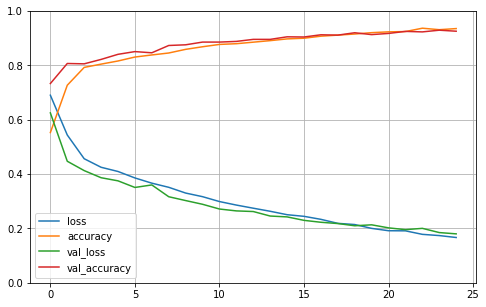

MODEL
make_DNN
input shape: (36, 4)
FIT
Epoch 1/25
200/200 [==============================] - 2s 5ms/step - loss: 0.6985 - accuracy: 0.5563 - val_loss: 0.5386 - val_accuracy: 0.7663
Epoch 2/25
200/200 [==============================] - 1s 3ms/step - loss: 0.5122 - accuracy: 0.7507 - val_loss: 0.4535 - val_accuracy: 0.8006
Epoch 3/25
200/200 [==============================] - 1s 3ms/step - loss: 0.4549 - accuracy: 0.7918 - val_loss: 0.4277 - val_accuracy: 0.8062
Epoch 4/25
200/200 [==============================] - 1s 3ms/step - loss: 0.4163 - accuracy: 0.8186 - val_loss: 0.4078 - val_accuracy: 0.8206
Epoch 5/25
200/200 [==============================] - 1s 3ms/step - loss: 0.4089 - accuracy: 0.8181 - val_loss: 0.3912 - val_accuracy: 0.8250
Epoch 6/25
200/200 [==============================] - 1s 3ms/step - loss: 0.3714 - accuracy: 0.8398 - val_loss: 0.3741 - val_accuracy: 0.8331
Epoch 7/25
200/200 [==============================] - 1s 3ms/step - loss: 0.3757 - accuracy: 0.8373 - val_lo

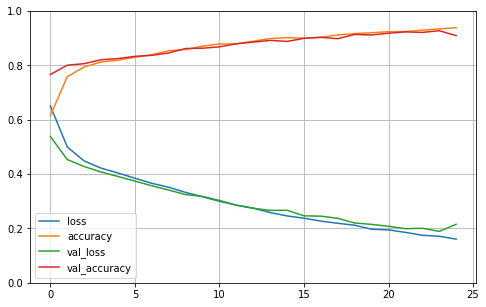

MODEL
make_DNN
input shape: (36, 4)
FIT
Epoch 1/25
200/200 [==============================] - 2s 5ms/step - loss: 0.7206 - accuracy: 0.5202 - val_loss: 0.5794 - val_accuracy: 0.7506
Epoch 2/25
200/200 [==============================] - 1s 3ms/step - loss: 0.5487 - accuracy: 0.7311 - val_loss: 0.4414 - val_accuracy: 0.7819
Epoch 3/25
200/200 [==============================] - 1s 3ms/step - loss: 0.4450 - accuracy: 0.7971 - val_loss: 0.4100 - val_accuracy: 0.8025
Epoch 4/25
200/200 [==============================] - 1s 3ms/step - loss: 0.4089 - accuracy: 0.8138 - val_loss: 0.3941 - val_accuracy: 0.8225
Epoch 5/25
200/200 [==============================] - 1s 3ms/step - loss: 0.3756 - accuracy: 0.8342 - val_loss: 0.3746 - val_accuracy: 0.8344
Epoch 6/25
200/200 [==============================] - 1s 3ms/step - loss: 0.3512 - accuracy: 0.8440 - val_loss: 0.3494 - val_accuracy: 0.8313
Epoch 7/25
200/200 [==============================] - 1s 3ms/step - loss: 0.3303 - accuracy: 0.8595 - val_lo

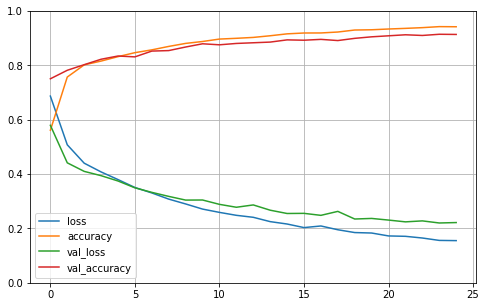

MODEL
make_DNN
input shape: (36, 4)
FIT
Epoch 1/25
200/200 [==============================] - 2s 5ms/step - loss: 0.7103 - accuracy: 0.5348 - val_loss: 0.5910 - val_accuracy: 0.7563
Epoch 2/25
200/200 [==============================] - 1s 3ms/step - loss: 0.5380 - accuracy: 0.7440 - val_loss: 0.4601 - val_accuracy: 0.7825
Epoch 3/25
200/200 [==============================] - 1s 3ms/step - loss: 0.4492 - accuracy: 0.7999 - val_loss: 0.4108 - val_accuracy: 0.8106
Epoch 4/25
200/200 [==============================] - 1s 3ms/step - loss: 0.4236 - accuracy: 0.8161 - val_loss: 0.3846 - val_accuracy: 0.8181
Epoch 5/25
200/200 [==============================] - 1s 3ms/step - loss: 0.3919 - accuracy: 0.8265 - val_loss: 0.3703 - val_accuracy: 0.8288
Epoch 6/25
200/200 [==============================] - 1s 3ms/step - loss: 0.3674 - accuracy: 0.8478 - val_loss: 0.3401 - val_accuracy: 0.8512
Epoch 7/25
200/200 [==============================] - 1s 3ms/step - loss: 0.3454 - accuracy: 0.8490 - val_lo

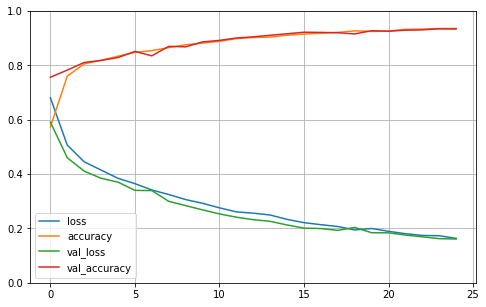

MODEL
make_DNN
input shape: (36, 4)
FIT
Epoch 1/25
200/200 [==============================] - 2s 5ms/step - loss: 0.7144 - accuracy: 0.5189 - val_loss: 0.6318 - val_accuracy: 0.7331
Epoch 2/25
200/200 [==============================] - 1s 3ms/step - loss: 0.5819 - accuracy: 0.7092 - val_loss: 0.4627 - val_accuracy: 0.7794
Epoch 3/25
200/200 [==============================] - 1s 3ms/step - loss: 0.4672 - accuracy: 0.7846 - val_loss: 0.4162 - val_accuracy: 0.8131
Epoch 4/25
200/200 [==============================] - 1s 3ms/step - loss: 0.4286 - accuracy: 0.8093 - val_loss: 0.3963 - val_accuracy: 0.8231
Epoch 5/25
200/200 [==============================] - 1s 3ms/step - loss: 0.3995 - accuracy: 0.8275 - val_loss: 0.3712 - val_accuracy: 0.8394
Epoch 6/25
200/200 [==============================] - 1s 3ms/step - loss: 0.3644 - accuracy: 0.8467 - val_loss: 0.3466 - val_accuracy: 0.8469
Epoch 7/25
200/200 [==============================] - 1s 3ms/step - loss: 0.3482 - accuracy: 0.8467 - val_lo

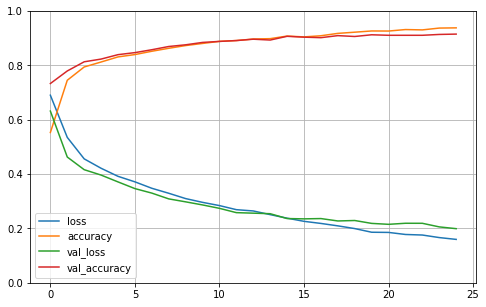

In [46]:
do_cross_validation(X,y)

In [47]:
from keras.models import load_model
X,y = prepare_inputs_len_x_alphabet(pc_test,nc_test,ALPHABET)
best_model=load_model(MODELPATH)
scores = best_model.evaluate(X, y, verbose=0)
print("The best model parameters were saved during cross-validation.")
print("Best was defined as maximum validation accuracy at end of any epoch.")
print("Now re-load the best model and test it on previously unseen data.")
print("Test on",len(pc_test),"PC seqs")
print("Test on",len(nc_test),"NC seqs")
print("%s: %.2f%%" % (best_model.metrics_names[1], scores[1]*100))


The best model parameters were saved during cross-validation.
Best was defined as maximum validation accuracy at end of any epoch.
Now re-load the best model and test it on previously unseen data.
Test on 1000 PC seqs
Test on 1000 NC seqs
accuracy: 93.30%


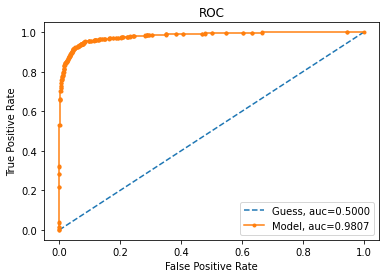

AUC: 98.07%


In [48]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
ns_probs = [0 for _ in range(len(y))]
bm_probs = best_model.predict(X)
ns_auc = roc_auc_score(y, ns_probs)
bm_auc = roc_auc_score(y, bm_probs)
ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)
bm_fpr, bm_tpr, _ = roc_curve(y, bm_probs)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Guess, auc=%.4f'%ns_auc)
plt.plot(bm_fpr, bm_tpr, marker='.', label='Model, auc=%.4f'%bm_auc)
plt.title('ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
print("%s: %.2f%%" %('AUC',bm_auc*100.0))


In [49]:
t = time.time()
time.strftime('%Y-%m-%d %H:%M:%S %Z', time.localtime(t))

'2021-06-11 19:22:02 UTC'